In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import nanonets
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
plt.style.use(["science","bright","grid"])

cm  = plt.get_cmap('cividis')
ma  = ["o","s","^","v","<",">"]

## DC Input - Voltage Distribution - Closed Circuit

In [34]:
def shift_and_append(dfs_dict):
    for name, df in dfs_dict.items():
        col1 = df.pop("1")  # remove column 1
        df.columns = range(df.shape[1])  # reassign column names to keep them sequential
        df[f"{len(df.columns)}"] = col1  # append column 1's data at the end
    return dfs_dict

folder1     = "/home/j/j_mens07/phd/data/2_funding_period/current/wo_magic_cable/dc_input_vs_volt/"
folder2     = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_volt/"
U0_vals     = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
N_p         = 10

N_voltages      = 50000
t_vals_closed   = np.arange(N_voltages-1)*1e-10*1e9
pot_closed      = {U_0 : pd.read_csv(f"{folder1}mean_state_Nx={N_p}_Ny=1_Ne=2_{U_0:.3f}.csv").round(5) for U_0 in U0_vals}
pot_closed      = shift_and_append(pot_closed)
pot_eq_closed   = pd.DataFrame([pot_closed[U_0].iloc[48000:,:].mean().values / U_0 for U_0 in U0_vals],index=U0_vals).T.round(2)
pot_open        = {U_0 : pd.read_csv(f"{folder2}mean_state_Nx={N_p}_Ny=1_Ne=2_{U_0:.3f}.csv").round(5) for U_0 in U0_vals}
pot_open        = shift_and_append(pot_open)
pot_eq_open     = pd.DataFrame([pot_open[U_0].iloc[48000:,:].mean().values / U_0 for U_0 in U0_vals],index=U0_vals).T.round(2)

### Steady State

In [35]:
pot_closed

{0.01:           0        1        2        3        4        5        6        7  \
 0      0.01  0.00275  0.00151  0.00109  0.00090  0.00077  0.00068  0.00061   
 1      0.01  0.00294  0.00159  0.00113  0.00092  0.00079  0.00070  0.00062   
 2      0.01  0.00329  0.00168  0.00118  0.00095  0.00082  0.00072  0.00065   
 3      0.01  0.00350  0.00173  0.00120  0.00097  0.00084  0.00074  0.00066   
 4      0.01  0.00364  0.00176  0.00122  0.00099  0.00085  0.00075  0.00067   
 ...     ...      ...      ...      ...      ...      ...      ...      ...   
 49994  0.01  0.00496  0.00609  0.00745  0.00642  0.00617  0.00546  0.00551   
 49995  0.01  0.00497  0.00615  0.00744  0.00635  0.00611  0.00545  0.00557   
 49996  0.01  0.00504  0.00617  0.00744  0.00631  0.00616  0.00547  0.00558   
 49997  0.01  0.00497  0.00616  0.00749  0.00624  0.00614  0.00540  0.00562   
 49998  0.01  0.00499  0.00611  0.00755  0.00630  0.00604  0.00540  0.00568   
 
              8        9       10   11  
 0 

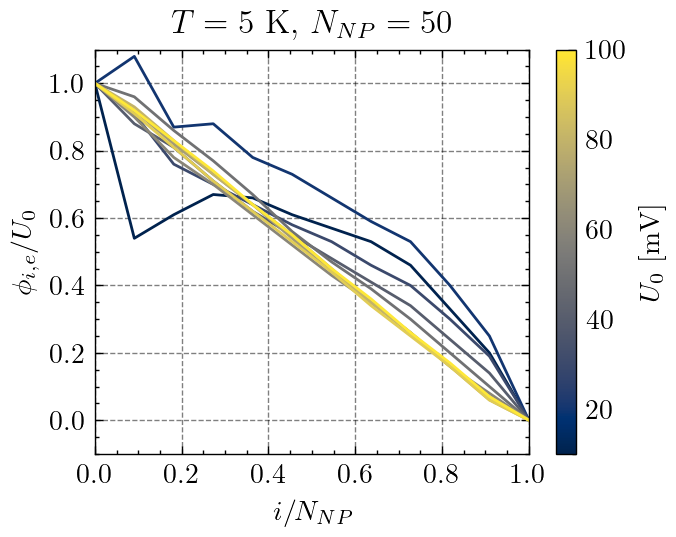

In [36]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(U0_vals)*1000, vmax=max(U0_vals)*1000)

for i, U_0 in enumerate(U0_vals):

    p   = pot_eq_closed[U_0].dropna().values.copy()
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(U_0*1000)))

ax.set_title("$T = 5$ K, $N_{NP} = 50$")
ax.set_ylim(-0.1,1.1)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_potential_vs_volt.svg", transparent=True)

Text(0.5, 12.31756469338072, '$i$')

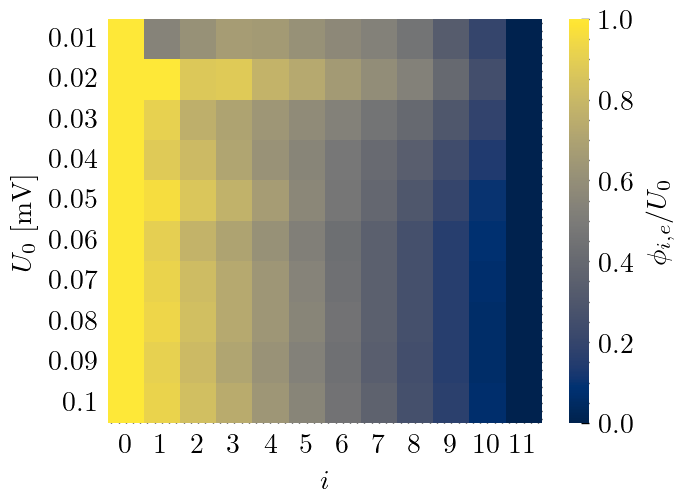

In [37]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(pot_eq_closed.T, cmap='cividis', vmin=0, vmax=1, cbar_kws={"label":"$\phi_{i,e} / U_0$"})
ax.set_ylabel("$U_0$ [mV]")
ax.set_xlabel("$i$")

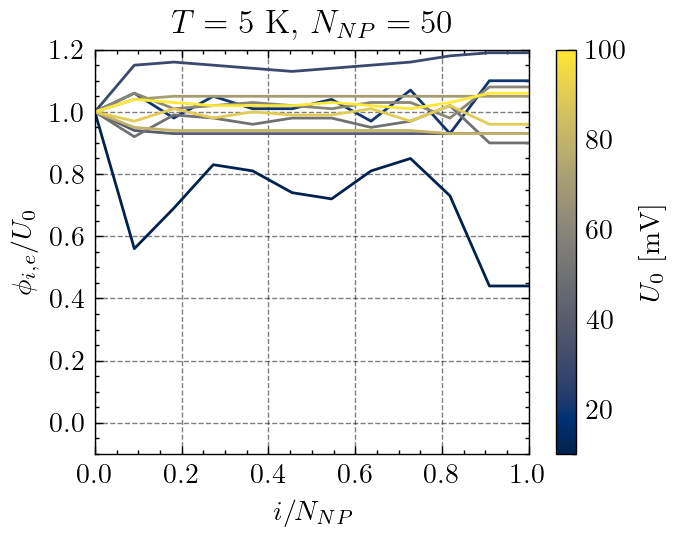

In [38]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(U0_vals)*1000, vmax=max(U0_vals)*1000)

for i, U_0 in enumerate(U0_vals):

    p   = pot_eq_open[U_0].dropna().values.copy()
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(U_0*1000)))

ax.set_title("$T = 5$ K, $N_{NP} = 50$")
ax.set_ylim(-0.1,1.2)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$U_0$ [mV]")

fig.savefig("../plots/dc_input/nonlinear/closed_circuit_node_potential_difference_vs_volt.svg", transparent=True)

### Characteristic Time Scale

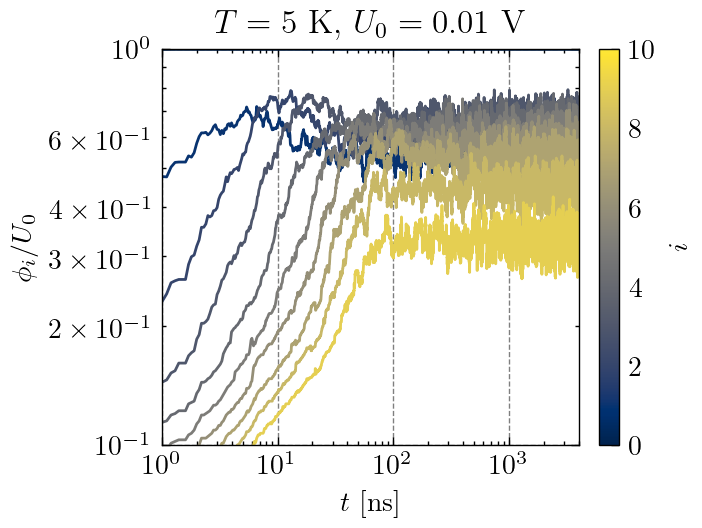

In [47]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=10)
Np      = 10
U_0     = 0.01

for i in range(Np):
    ax.plot(t_vals_closed, pot_closed[U_0][i].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_xlim(1,4000)
ax.set_ylim(0.1,1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

# fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_series.svg", transparent=True)

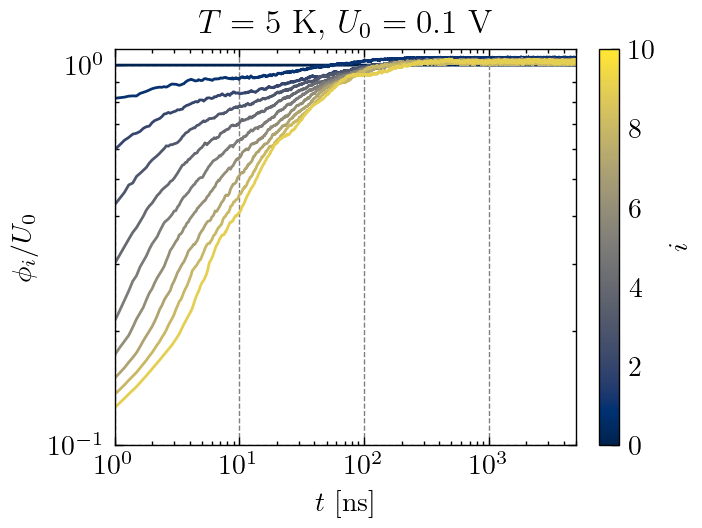

In [56]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=10)
Np      = 10
U_0     = 0.1

for i in range(Np):
    ax.plot(t_vals_closed, pot_open[U_0][i].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 5$ K, $U_0 = {U_0}$ V")
ax.set_xlim(1,5000)
ax.set_ylim(0.1,1.1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

# fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_series.svg", transparent=True)

Text(42.06756469338072, 0.5, '$k$')

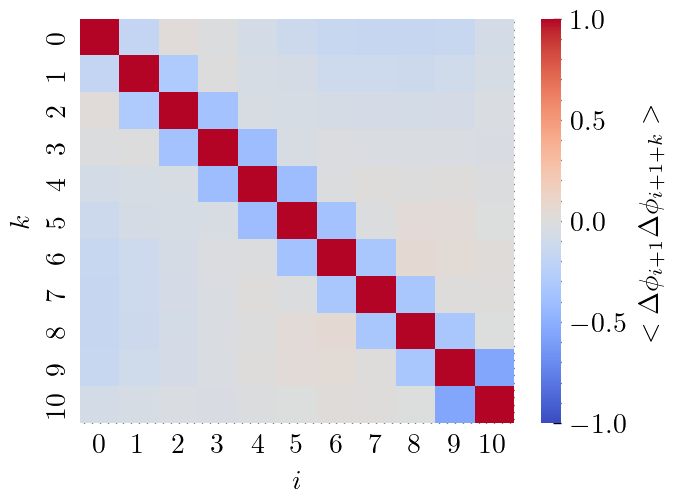

In [59]:
U_0     = 0.1
p_diff  = pot_closed[U_0].diff(axis=1).drop(columns=0).values
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax, cbar_kws={"label":"$<\Delta\phi_{i+1}\Delta\phi_{i+1+k}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")

Text(42.06756469338072, 0.5, '$k$')

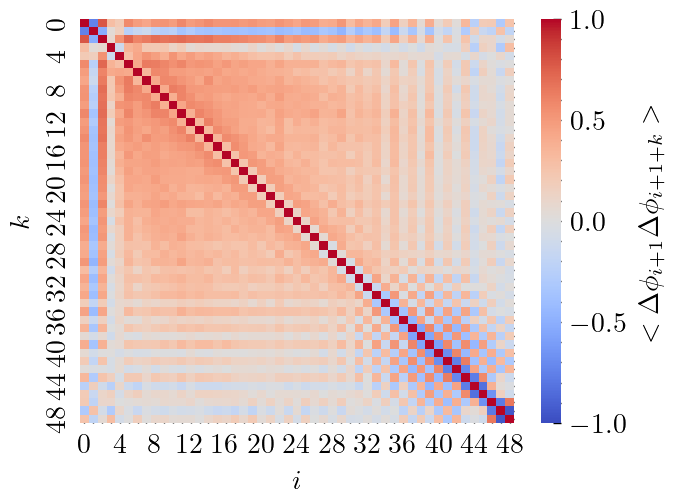

In [101]:
U_0     = 0.1
p_diff  = pot_open[U_0].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax, cbar_kws={"label":"$<\Delta\phi_{i+1}\Delta\phi_{i+1+k}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")

- Strong short range correlations: Diffusive charge spreading
- Long range anti-correlations: Charges at distant NPs adjust to maintain linear potential gradient globally

In [8]:
def characteristic_time(t_vals, pot_df, Np, steady_start=20000, consecutive_points=50, p_th=0.63):

    end_vals    = pot_df[Np].iloc[steady_start:,:].mean().values
    taus        = []
    p_th        = 0.63

    for i in range(Np):
        vals        = pot_df[Np].loc[:,f'{i}'].values
        threshold   = p_th*end_vals[i]
        above_th    = vals > threshold
        for j in range(len(above_th) - consecutive_points):
            if all(above_th[j:j+consecutive_points]):
                tau = t_vals[j]
                taus.append(tau)
                break
    
    return taus

def characteristic_time_saturation(t_vals, pot_df, Np):

    def saturation_cuve(t, tau, a0):
        return a0*(1 - np.exp(-(t) / tau))

    tau = []
    std = []
    for i in range(Np):
        x       = t_vals.copy()
        y       = pot_df[Np].loc[:,f'{i}'].values
        p, cov  = curve_fit(saturation_cuve, x, y, bounds=((0,0),(np.inf,np.inf)))
        tau.append(p[0])
        std.append(np.sqrt(cov[0,0]))

    return tau, std

def characteristic_time_stretched_saturation(t_vals, pot_df, Np, p0=None):

    def stretched_saturation_curve(t, tau, a0, beta):
        return a0*(1 - np.exp(-((t/tau)**beta)))

    tau = []
    for i in range(Np):
        x       = t_vals.copy()
        y       = pot_df[Np].loc[:,f'{i}'].values
        p, cov  = curve_fit(stretched_saturation_curve, x, y, p0=p0, bounds=((0,0,0),(np.inf,np.inf,np.inf)), maxfev=5000)
        tau_val = gamma(1/p[2])*p[0]/p[2]
        tau.append(tau_val)
        # print(p)

    return tau

def mode_time_scale_theory(n: int, R: float, Cm: float, Cs: float, N: int)->float:
    """Characteristic Time of mode n in a string of N Nanoparticles

    Parameters
    ----------
    n : int
        nth mode [1,N]
    R : float
        Junction resistance
    Cm : float
        Mutual capacitance
    Cs : float
        Self capacitance
    N : int
        Number of Nanoparticles in String

    Returns
    -------
    float
        Mode time scale
    """
    a   = R*(Cs+2*Cm*(1-np.cos(n*np.pi/(N+1))))
    b   = 2*(1-np.cos(n*np.pi/(N+1)))
    return a/b

In [9]:
Np                  = 50
taus_hot, std_hot   = characteristic_time_saturation(t_vals, pot, Np)
taus_hot_stretched  = characteristic_time_stretched_saturation(t_vals, pot, Np, p0=[5,1,1])

Text(0.5, 1.0, '$T = 293$ K, $U_0 = 1.0$ V')

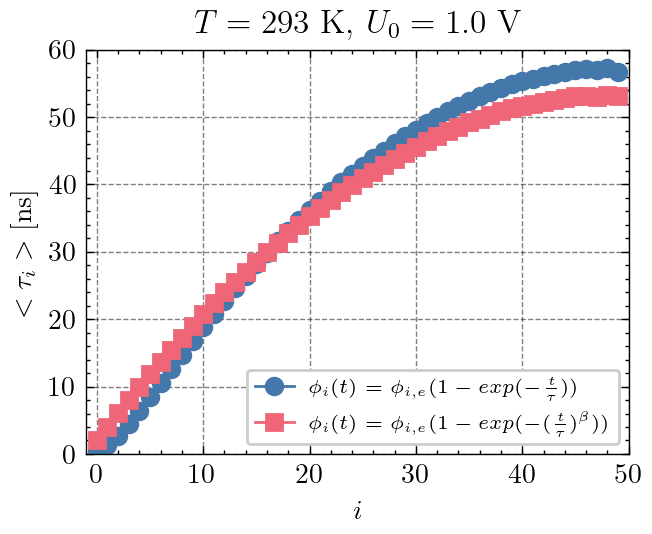

In [10]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
xp  = range(Np)
ax.plot(xp, taus_hot, '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(xp, taus_hot_stretched, '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$<\\tau_i>$ [ns]")
ax.set_ylim(0,60)
ax.set_xlim(-1,50)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

# fig.savefig("../plots/dc_input/linear/closed_circuit_node_time_scales.svg", transparent=True)

In [11]:
1/(2*np.pi)

0.15915494309189535

In [137]:
def mode_time_scale_theory(n: int, R: float, Cm: float, Cs: float, N: int)->float:
    a       = R*(Cs+2*Cm*(1-np.cos(n*np.pi/(N+1))))
    b       = 2*(1-np.cos(n*np.pi/(N+1)))
    return a/b

def solve_a_values(U0: float, N: int)->np.ndarray:
    i_vals = np.arange(1, N + 1)
    n_vals = np.arange(1, N + 1)
    S       = np.array([[np.sin(n * np.pi * i / (N + 1)) for n in n_vals] for i in i_vals])
    rhs     = -U0 * (1 - i_vals / (N + 1))
    return np.linalg.solve(S, rhs)


In [28]:
tau_s               = []
tau_s_stretched     = []

for Np in N_vals:
    taus, std   = characteristic_time_saturation(t_vals, pot, Np)
    tau_s.append(np.max(taus))
    # taus        = characteristic_time_stretched_saturation(t_vals, pot, Np)
    # tau_s_stretched.append(np.max(taus))

tau_i_n0    = mode_time_scale_theory(1, R, Cm, Cs, np.array(N_vals))

In [103]:
tau_i   = []

for N in N_vals:
    tau_n   = mode_time_scale_theory(np.arange(1,N+1),R,Cm,Cs,N)
    a_n     = -solve_a_values(U_0, N)
    tau_sum = np.sum(tau_n)
    tau_i.append(tau_sum*1e9)

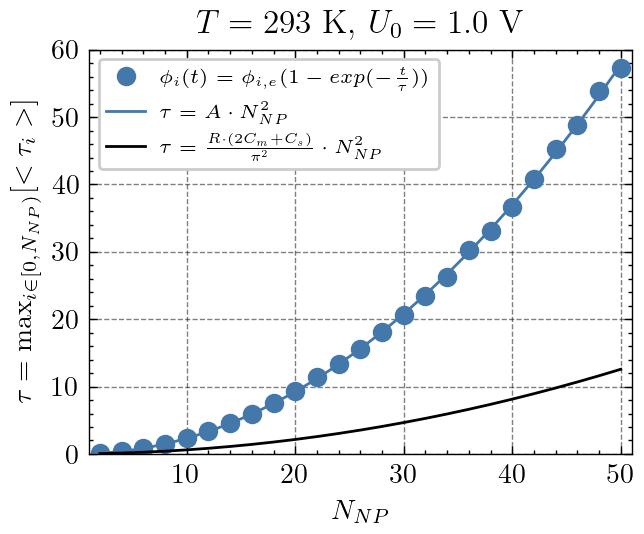

In [65]:
def quad_func(x, a):
    return a*x**2

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

p,_ = curve_fit(quad_func, N_vals, tau_s)
pp  = ax.plot(N_vals, tau_s, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

p,_ = curve_fit(quad_func, N_vals, tau_s_stretched)
pp  = ax.plot(N_vals, tau_s_stretched, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

# ax.plot(N_vals, quad_func(np.array(N_vals), R*(2*Cm+Cs)*1e9 / (np.pi**2)), color='black', label="$\\tau = \\frac{R \cdot (2C_m + C_s)}{\pi^2} \cdot N_{NP}^2$")
ax.plot(N_vals, tau_i, color='black', label="$\\tau = \\frac{R \cdot (2C_m + C_s)}{\pi^2} \cdot N_{NP}^2$")

# ax.set_ylabel("$\\underset{i \in [0,N_{NP})}{\max} <\\tau_i>$")
ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[<\\tau_i>]$")
ax.set_ylim(0,60)
ax.set_xlim(1,51)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/linear/closed_circuit_time_scales_vs_N.svg", transparent=True)

- $N^2$ dependence as we have **diffusive-limited relaxation** (governed by $R$ and $C$)
- We get about the same prefactor as theory suggests. Deviations due to finite-$N$
- We have a ***hierarchical timescale*** of eigenmodes, i.e. first NPs relax faster and last NP are driven by slowest mode

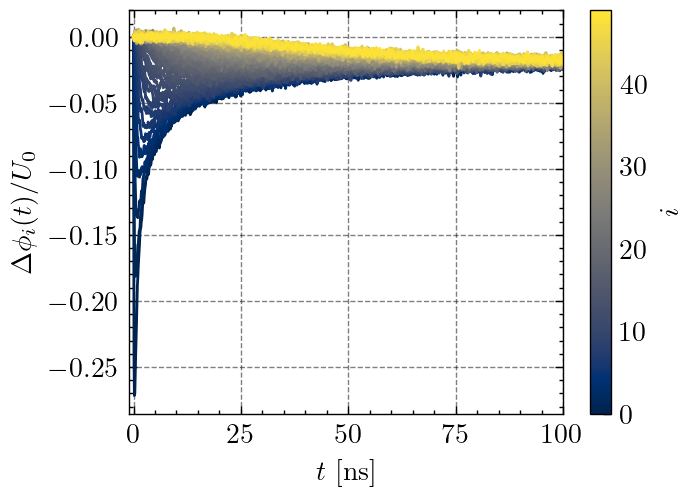

In [105]:
Np      = 50
norm    = Normalize(vmin=0, vmax=(Np-1))
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0, color=cm(norm(i)), label=f'${i}$')
ax.set_xlim(-1,100)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

# ax.legend(fontsize='x-small', ncol=2)

## DC Input - Voltage Distribution - Open Circuit

In [141]:
# folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/293/"
folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/wo_magic_cable/dc_input_vs_size/293/"
N_voltages  = 40000
U_0         = 1.0
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
N_vals      = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
pot         = {N_p : pd.read_csv(f"{folder}mean_state_Nx={N_p}_Ny=1_Nz=1_Ne=2.csv") for N_p in N_vals}
pot_eq      = pd.DataFrame([pot[N_p].iloc[38000:,:].mean().values / U_0 for N_p in N_vals],index=N_vals).T.round(2)

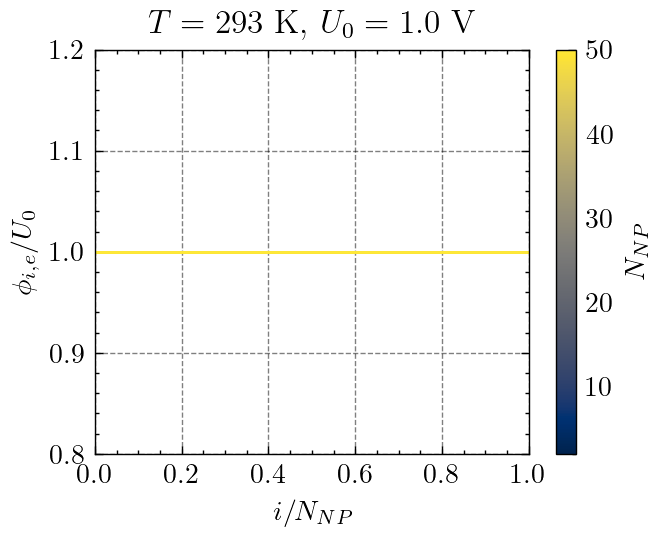

In [142]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    p   = pot_eq[N].dropna().values.copy()
    p   = np.insert(p, 0, 1.0)
    x   = np.linspace(0,1,len(p))
    ax.plot(x, p, color=cm(norm(N)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_ylim(0.8,1.2)
ax.set_xlim(0,1)
ax.set_ylabel("$\phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_potential.svg", transparent=True)

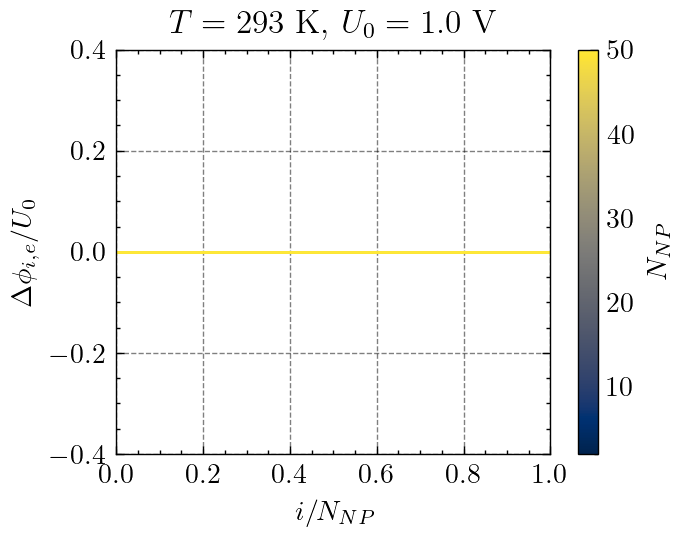

In [143]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = Normalize(vmin=min(N_vals), vmax=max(N_vals))

for i, N in enumerate(N_vals):

    arr = pot_eq[N].dropna().values.copy()*U_0
    arr = np.insert(arr, 0, U_0)
    arr = np.diff(arr)/U_0
    x   = np.linspace(0,1,len(arr))

    ax.plot(x, arr, color=cm(norm(N)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_xlim(0,1)
ax.set_ylim(-0.4, 0.4)
ax.set_ylabel("$\Delta \phi_{i,e} / U_0$")
ax.set_xlabel("$i / N_{NP}$")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$N_{NP}$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_potential_difference.svg", transparent=True)

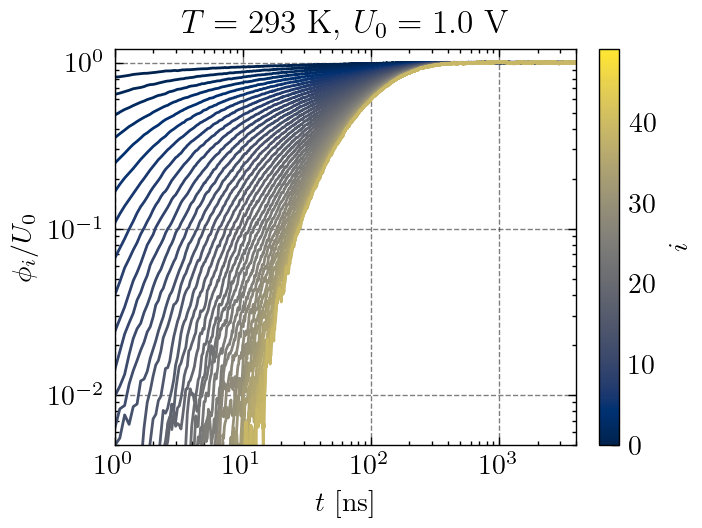

In [144]:
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot()
norm    = Normalize(vmin=0, vmax=49)
Np      = 40

for i in range(Np):
    ax.plot(t_vals, pot[Np][f"{i}"].values/U_0, color=cm(norm(i)))

ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")
ax.set_xlim(1,4000)
ax.set_ylim(0.005,1.2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("$\phi_i / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_time_series.svg", transparent=True)

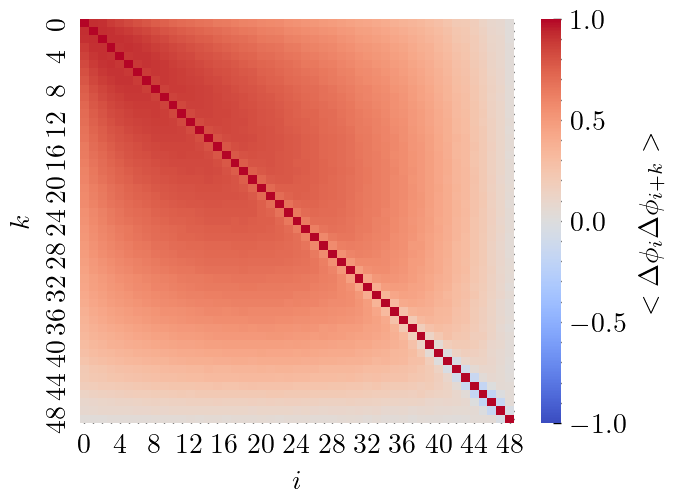

In [145]:
Np      = 50
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
delta_p = pd.DataFrame(p_diff)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax  = sns.heatmap(delta_p.corr(), cmap='coolwarm', vmin=-1, vmax=1, ax=ax, cbar_kws={"label":"$<\Delta\phi_i\Delta\phi_{i+k}>$"})
ax.set_xlabel("$i$")
ax.set_ylabel("$k$")

fig.savefig("../plots/dc_input/linear/open_circuit_node_pot_diff_corr.svg", transparent=True)

- Without a ground path, charges accumulate until the **entire string floats** at $U_0$ --> $\phi_i \approx U_0 \forall i$

In [146]:
Np                  = 50
taus_hot, std_hot   = characteristic_time_saturation(t_vals, pot, Np)
taus_hot_stretched  = characteristic_time_stretched_saturation(t_vals, pot, Np, p0=[5,1,1])

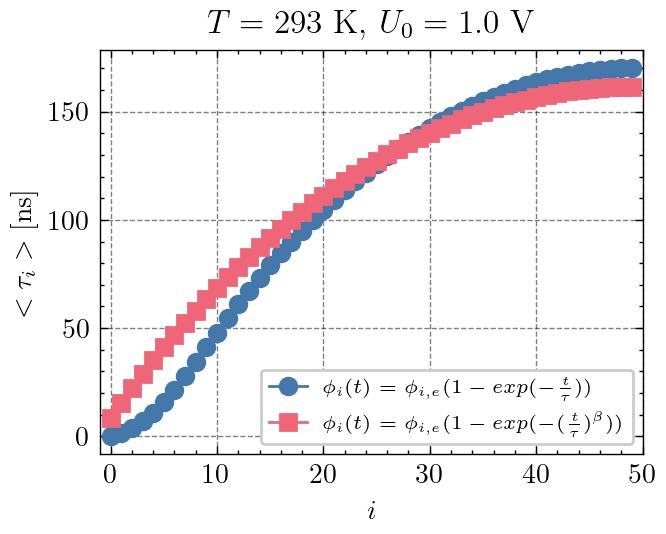

In [147]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
xp  = range(Np)
ax.plot(xp, taus_hot, '-o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(xp, taus_hot_stretched, '-s', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.set_xlabel("$i$")
ax.set_ylabel("$<\\tau_i>$ [ns]")
# ax.set_ylim(0,60)
ax.set_xlim(-1,50)
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/linear/open_circuit_node_time_scales.svg", transparent=True)

In [148]:
np.max(taus_hot_stretched)

np.float64(161.60919639527583)

In [84]:
tau_s               = []
tau_s_stretched     = []

for Np in N_vals:
    taus, std   = characteristic_time_saturation(t_vals, pot, Np)
    tau_s.append(np.max(taus))
    taus        = characteristic_time_stretched_saturation(t_vals, pot, Np)
    tau_s_stretched.append(np.max(taus))

ValueError: `ydata` must not be empty!

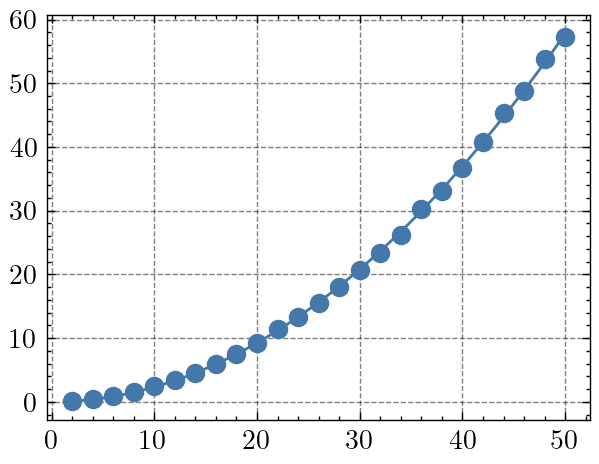

In [123]:
def quad_func(x, a):
    return a*x**2

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()

p,_ = curve_fit(quad_func, N_vals, tau_s)
pp  = ax.plot(N_vals, tau_s, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-\\frac{t}{\\tau}))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

p,_ = curve_fit(quad_func, N_vals, tau_s_stretched)
pp  = ax.plot(N_vals, tau_s_stretched, 'o', label="$\phi_i(t) = \phi_{i,e}(1 - exp(-(\\frac{t}{\\tau})^\\beta))$")
ax.plot(N_vals, quad_func(np.array(N_vals), *p), color=pp[0].get_color(), label="$\\tau = A \cdot N_{NP}^2$")

ax.plot(N_vals, quad_func(np.array(N_vals), R*Cm*1e9), color='black', label="$\\tau = RC \cdot N_{NP}^2$")

# ax.set_ylabel("$\\underset{i \in [0,N_{NP})}{\max} <\\tau_i>$")
ax.set_ylabel("$\\tau = \max_{i \in [0,N_{NP})}[<\\tau_i>]$")
ax.set_ylim(0,200)
ax.set_xlim(1,51)
ax.set_xlabel("$N_{NP}$")
ax.legend(fontsize='x-small')
ax.set_title(f"$T = 293$ K, $U_0 = {U_0}$ V")

fig.savefig("../plots/dc_input/linear/open_circuit_time_scales_vs_N.svg", transparent=True)

In [121]:
N   = 50
n   = 7

print(np.cos((2*n-1)*np.pi*N/(2*N)))
print(np.cos((2*n-1)*np.pi*(N+1)/(2*N)))

-9.803364199544708e-16
-0.3971478906347843


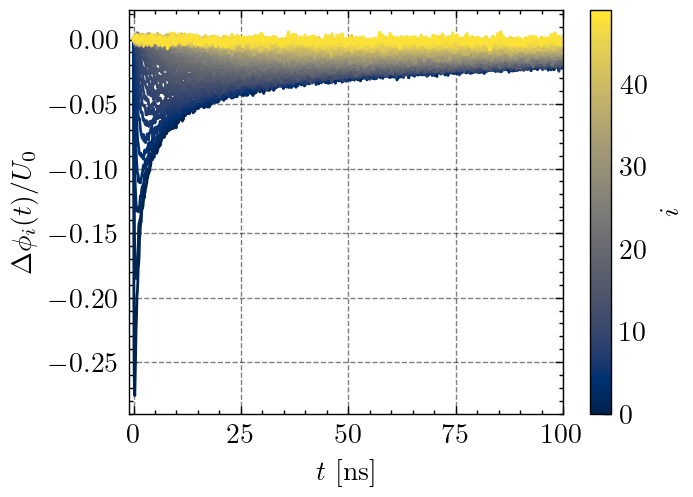

In [78]:
Np      = 50
norm    = Normalize(vmin=0, vmax=(Np-1))
t_f_d   = np.arange(N_voltages)*1e-10*1e9
p_diff  = pot[Np].diff(axis=1).drop(columns="0").values
p_diff  = np.insert(p_diff, 0, np.zeros(Np-1), axis=0)
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
for i in range(Np-1):
    ax.plot(t_f_d, p_diff[:,i]/U_0, color=cm(norm(i)), label=f'${i}$')
ax.set_xlim(-1,100)
ax.set_ylabel("$\Delta \phi_i(t) / U_0$")
ax.set_xlabel("$t$ [ns]")

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$i$")

# ax.legend(fontsize='x-small', ncol=2)

In [101]:
N_periods   = 40
time_step   = 1e-9
f0          = 10*1e6
T0          = 1 / f0
N_samples_p = int(T0 / time_step)
N_voltages  = int(N_periods*N_samples_p)
N_voltages

3960

In [99]:
T0 / time_step

9.999999999999999e-16

---